# Exploratory Data Analysis for Stock Price Prediction

## Analytical Objective

This notebook conducts comprehensive exploratory data analysis focused on **stock price prediction** using our engineered feature set. The analysis examines price patterns, feature relationships with price levels, and temporal characteristics that will inform our price forecasting models.

## EDA Framework for Price Modeling

Our exploratory analysis addresses the specific challenges of price prediction:

**Price Level Analysis**: Examination of absolute price trends, levels, and patterns rather than returns, since we're predicting future price levels.

**Feature-Price Relationships**: Analysis of how engineered features correlate with and predict actual stock prices, not price changes.

**Temporal Price Patterns**: Investigation of price trends, seasonality, and regime changes that affect price forecasting accuracy.

**Price Forecasting Challenges**: Identification of non-stationarity, trend persistence, and other characteristics specific to price level prediction.

**Model-Relevant Insights**: Analysis focused on the specific requirements and challenges of predicting absolute price values rather than return distributions.

The analysis provides insights specifically relevant to price forecasting models and the unique challenges of predicting price levels in financial markets.


## Environment Setup and Data Loading

Initialize the analysis environment and load our engineered feature dataset for price-focused exploratory analysis.


In [10]:
# Initialize EDA environment for price prediction analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Define analysis target
ticker = input("Enter the ticker symbol to analyze (or press Enter to use AAPL): ").upper() or "AAPL"
print(f"Price prediction EDA for {ticker}")
print("Focus: Stock price levels and forecasting characteristics")

Price prediction EDA for MSFT
Focus: Stock price levels and forecasting characteristics


In [11]:
# Load engineered feature dataset
try:
    df = pd.read_csv(f'../data/final/{ticker}/preprocessed_features.csv')
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    
    print(f"Dataset loaded successfully: {df.shape}")
    print(f"Analysis period: {df.index.min()} to {df.index.max()}")
    print(f"Features available: {len(df.columns)}")
    
    # Identify target variable and feature categories
    target_col = 'Close'
    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    tech_cols = [col for col in df.columns if any(indicator in col for indicator in ['SMA', 'EMA', 'RSI', 'ATR', 'Bollinger', 'OBV'])]
    econ_cols = [col for col in df.columns if any(indicator in col for indicator in ['CPI', 'PPI', 'Fed_Funds', 'Treasury', 'Unemployment', 'Industrial', 'Consumer', 'Housing'])]
    market_cols = [col for col in df.columns if any(indicator in col for indicator in ['S&P', 'NASDAQ', 'Dow', 'VIX', 'Sector'])]
    
    print(f"Price features: {len(price_cols)}")
    print(f"Technical indicators: {len(tech_cols)}")
    print(f"Economic features: {len(econ_cols)}")
    print(f"Market context features: {len(market_cols)}")
    
except FileNotFoundError:
    print(f"Preprocessed features not found for {ticker}")
    print("Please run feature engineering notebook first")
    raise


Dataset loaded successfully: (451, 33)
Analysis period: 2023-09-01 00:00:00 to 2025-06-20 00:00:00
Features available: 33
Price features: 5
Technical indicators: 8
Economic features: 13
Market context features: 5


## Data Quality Assessment

The first phase of our analysis examines data quality characteristics that could impact model performance. This includes missing value patterns, outlier identification, and data consistency validation.


In [12]:
# Comprehensive data quality assessment
print("=== DATA QUALITY ANALYSIS ===")

# Missing value analysis
missing_analysis = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing_Percent', ascending=False)

print(f"Missing value summary:")
print(f"Features with missing values: {(missing_analysis['Missing_Count'] > 0).sum()}")
print(f"Maximum missing percentage: {missing_analysis['Missing_Percent'].max():.2f}%")

if missing_analysis['Missing_Count'].sum() > 0:
    print("\nFeatures with missing values:")
    print(missing_analysis[missing_analysis['Missing_Count'] > 0])
else:
    print("No missing values detected - excellent data quality")

# Basic descriptive statistics
print(f"\n=== DESCRIPTIVE STATISTICS ===")
desc_stats = df.describe()
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data type analysis
print(f"\nData types distribution:")
print(df.dtypes.value_counts())

# Outlier detection using IQR method
print(f"\n=== OUTLIER ANALYSIS ===")
outlier_summary = []
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_pct = (outliers / len(df)) * 100
    outlier_summary.append({'Feature': col, 'Outliers': outliers, 'Outlier_Pct': outlier_pct})

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_Pct', ascending=False)
print(f"Features with highest outlier percentages:")
print(outlier_df.head(10))

=== DATA QUALITY ANALYSIS ===
Missing value summary:
Features with missing values: 0
Maximum missing percentage: 0.00%
No missing values detected - excellent data quality

=== DESCRIPTIVE STATISTICS ===
Dataset shape: (451, 33)
Memory usage: 0.12 MB

Data types distribution:
float64    31
int64       2
Name: count, dtype: int64

=== OUTLIER ANALYSIS ===
Features with highest outlier percentages:
                  Feature  Outliers  Outlier_Pct
2      Consumer_Sentiment       100    22.172949
6          Housing_Starts        60    13.303769
26                    OBV        49    10.864745
7   Industrial_Production        43     9.534368
23        Bollinger_Upper        33     7.317073
20                 SMA_50        31     6.873614
18                 Volume        28     6.208426
22                    ATR        27     5.986696
5                    High        22     4.878049
1                   Close        21     4.656319


## Stock Price Analysis

Analysis of our target variable - stock price levels. Since we're predicting future prices (not returns), we focus on price trends, levels, and forecasting characteristics.


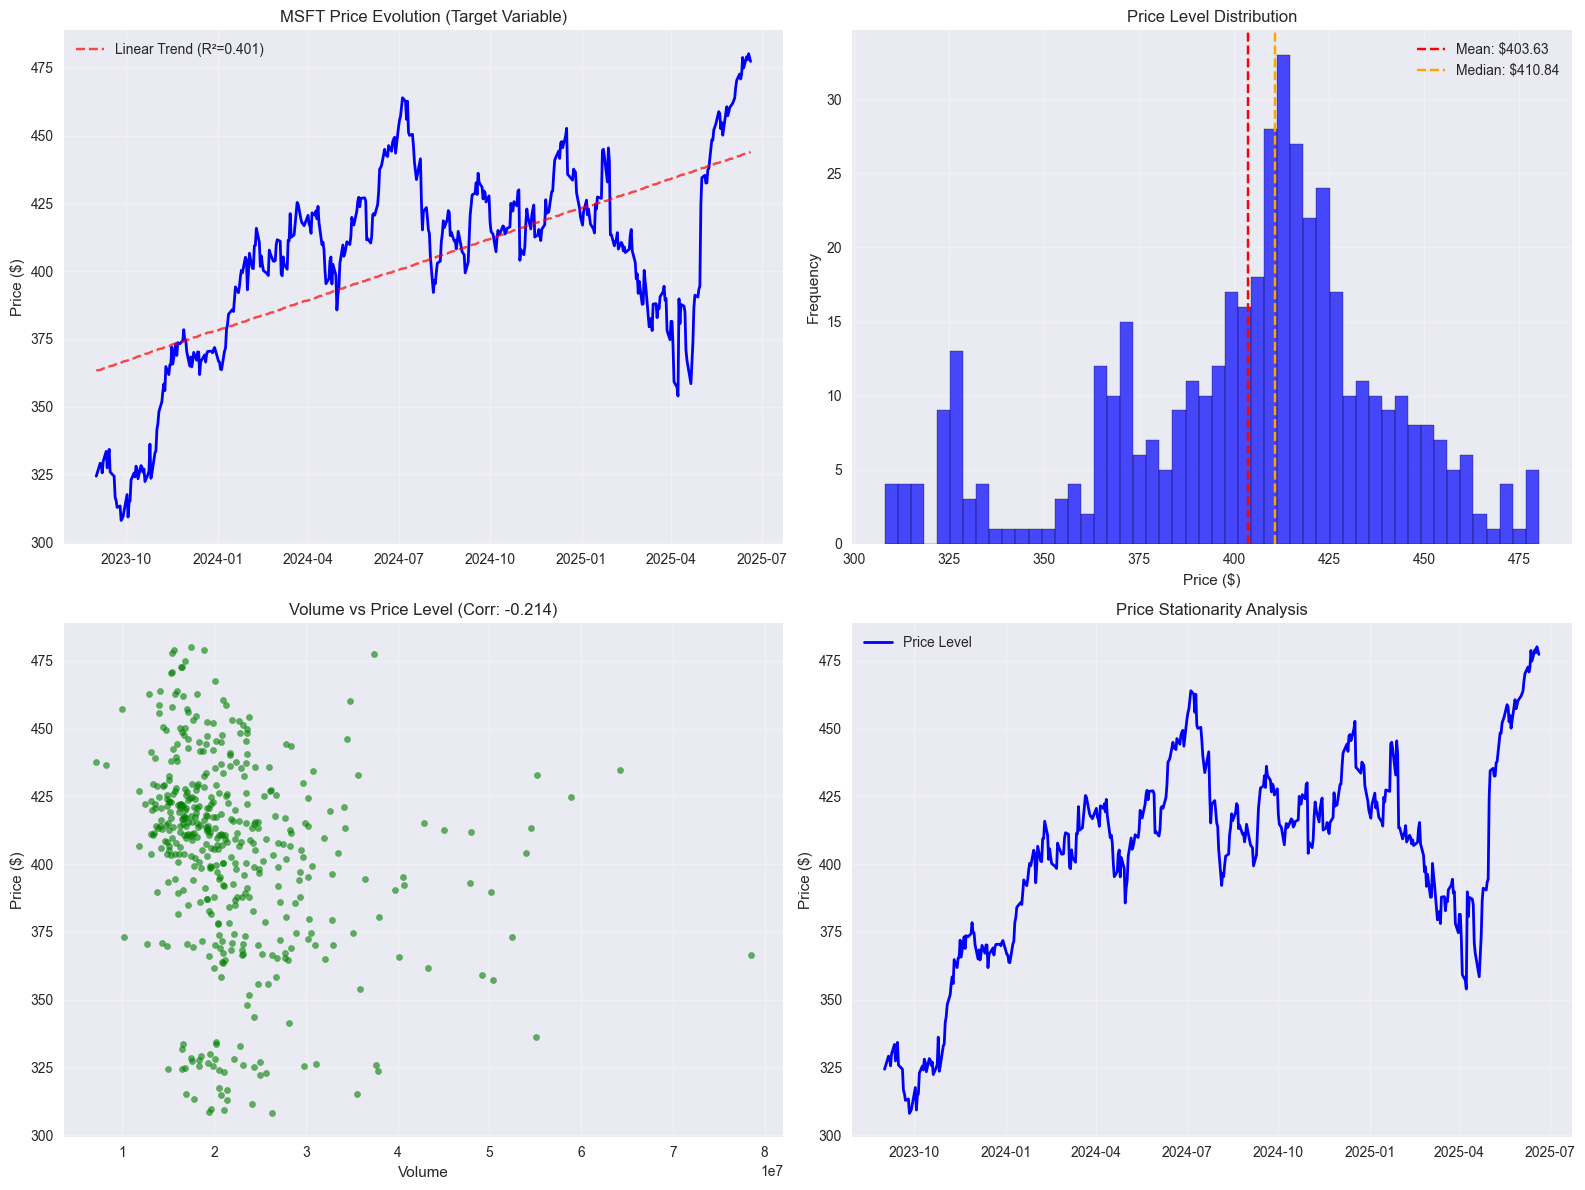

=== PRICE FORECASTING CHARACTERISTICS ===
Current Price: $477.40
Min Price: $308.01
Max Price: $480.24
Price Range: $172.23
Mean Price: $403.63
Price Std Dev: $36.84
Price Trend ($/day): $0.18
Trend R-squared: 0.4010
Trend Significance: Significant

=== PRICE STATIONARITY TEST ===
Augmented Dickey-Fuller Test Results:
ADF Statistic: -1.766973
p-value: 0.396978
Critical Values: {'1%': -3.444965543297668, '5%': -2.8679842369272976, '10%': -2.5702025382716047}
⚠ Price series is NON-STATIONARY - requires careful modeling approach
  Consider: trend modeling, differencing, or detrending techniques

=== PRICE CHANGE PATTERNS ===
Mean daily price change: $0.3402
Std dev of price changes: $5.7816
Max daily price increase: $35.86
Max daily price decrease: $-27.24
Price change volatility: 1.43% of mean price


In [13]:
# Price-focused analysis for price prediction modeling
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Price evolution and trend analysis (our target variable)
axes[0,0].plot(df.index, df['Close'], linewidth=2, color='blue')
axes[0,0].set_title(f'{ticker} Price Evolution (Target Variable)')
axes[0,0].set_ylabel('Price ($)')
axes[0,0].grid(True, alpha=0.3)

# Add trend line for price forecasting context
x_numeric = np.arange(len(df))
slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, df['Close'])
trend_line = slope * x_numeric + intercept
axes[0,0].plot(df.index, trend_line, 'r--', alpha=0.7, label=f'Linear Trend (R²={r_value**2:.3f})')
axes[0,0].legend()

# 2. Price level distribution (not returns)
axes[0,1].hist(df['Close'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0,1].set_title('Price Level Distribution')
axes[0,1].set_xlabel('Price ($)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axvline(df['Close'].mean(), color='red', linestyle='--', label=f'Mean: ${df["Close"].mean():.2f}')
axes[0,1].axvline(df['Close'].median(), color='orange', linestyle='--', label=f'Median: ${df["Close"].median():.2f}')
axes[0,1].legend()

# 3. Volume vs Price relationship (relevant for price prediction)
axes[1,0].scatter(df['Volume'], df['Close'], alpha=0.6, color='green', s=20)
volume_price_corr = df['Volume'].corr(df['Close'])
axes[1,0].set_title(f'Volume vs Price Level (Corr: {volume_price_corr:.3f})')
axes[1,0].set_xlabel('Volume')
axes[1,0].set_ylabel('Price ($)')
axes[1,0].grid(True, alpha=0.3)

# 4. Price stationarity analysis (critical for price forecasting)
axes[1,1].plot(df.index, df['Close'], label='Price Level', color='blue', linewidth=2)
axes[1,1].set_title('Price Stationarity Analysis')
axes[1,1].set_ylabel('Price ($)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Price statistics for forecasting
print("=== PRICE FORECASTING CHARACTERISTICS ===")
price_stats = {
    'Current Price': df['Close'].iloc[-1],
    'Min Price': df['Close'].min(),
    'Max Price': df['Close'].max(),
    'Price Range': df['Close'].max() - df['Close'].min(),
    'Mean Price': df['Close'].mean(),
    'Price Std Dev': df['Close'].std(),
    'Price Trend ($/day)': slope,
    'Trend R-squared': r_value**2,
    'Trend Significance': 'Significant' if p_value < 0.05 else 'Not Significant'
}

for key, value in price_stats.items():
    if isinstance(value, str):
        print(f"{key}: {value}")
    elif 'R-squared' in key:
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: ${value:.2f}")

# Stationarity test (crucial for price prediction)
adf_result = adfuller(df['Close'])
print(f"\n=== PRICE STATIONARITY TEST ===")
print(f"Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")
print(f"Critical Values: {dict(adf_result[4])}")

if adf_result[1] < 0.05:
    print("✓ Price series is STATIONARY - good for direct price modeling")
else:
    print("⚠ Price series is NON-STATIONARY - requires careful modeling approach")
    print("  Consider: trend modeling, differencing, or detrending techniques")

# Price change characteristics (but focus on levels)
price_changes = df['Close'].diff().dropna()
print(f"\n=== PRICE CHANGE PATTERNS ===")
print(f"Mean daily price change: ${price_changes.mean():.4f}")
print(f"Std dev of price changes: ${price_changes.std():.4f}")
print(f"Max daily price increase: ${price_changes.max():.2f}")
print(f"Max daily price decrease: ${price_changes.min():.2f}")
print(f"Price change volatility: {price_changes.std() / df['Close'].mean() * 100:.2f}% of mean price")


## Feature-Price Relationships

Analysis of how our engineered features correlate with stock price levels. This is crucial for understanding which features are most predictive of future prices.


=== FEATURES MOST CORRELATED WITH PRICE LEVELS ===
(Ranked by absolute correlation - key for price prediction)

Strongest POSITIVE correlations with price:
Low                           :  0.997
High                          :  0.997
Open                          :  0.992
EMA_20                        :  0.947
Bollinger_Upper               :  0.932
SMA_20                        :  0.926
S&P_500                       :  0.899
OBV                           :  0.876
Bollinger_Lower               :  0.861

Strongest NEGATIVE correlations with price:
CPI_YoY_Change                : -0.513
Treasury_3M                   : -0.412
Fed_Funds_Rate                : -0.321
Housing_Starts                : -0.250
Volume                        : -0.214


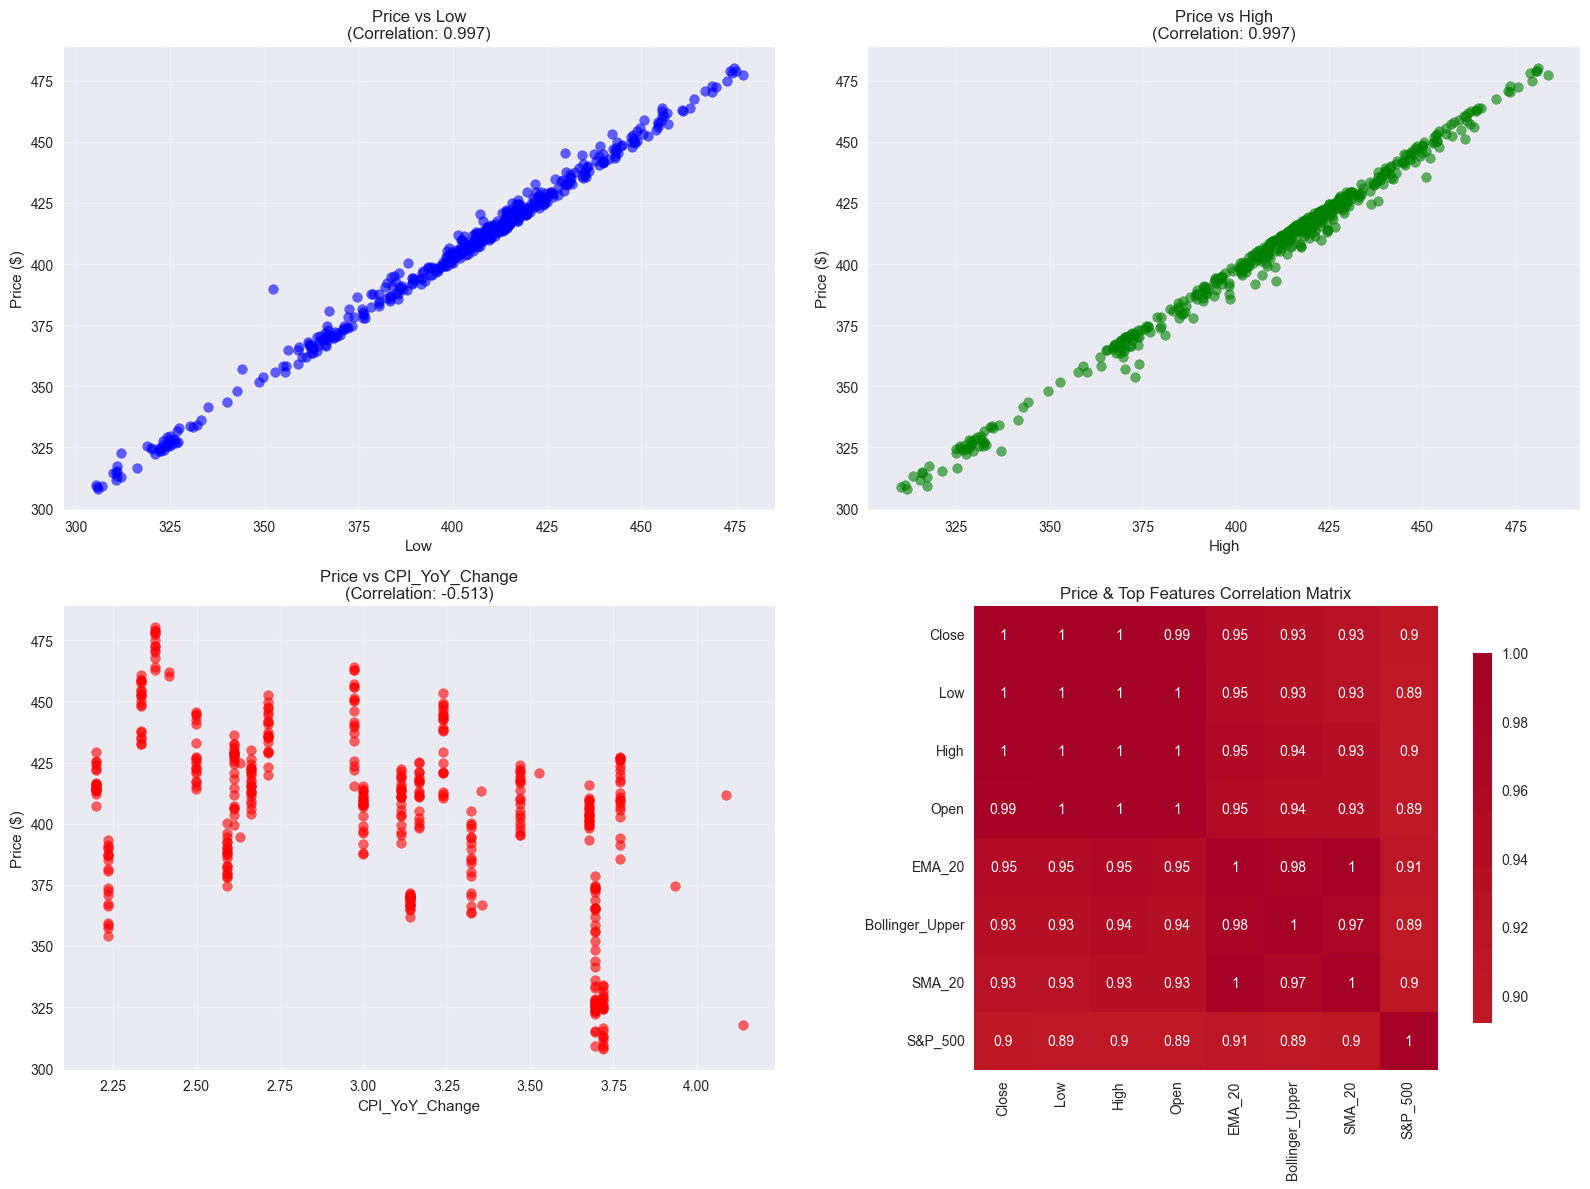


=== PRICE PREDICTION INSIGHTS ===
Features with correlation > 0.7 with price: 13
Features with correlation > 0.5 with price: 17
Features with correlation > 0.3 with price: 20

Strongest price predictors (|correlation| > 0.5):
  Low: 0.997
  High: 0.997
  Open: 0.992
  EMA_20: 0.947
  Bollinger_Upper: 0.932
  SMA_20: 0.926
  S&P_500: 0.899
  OBV: 0.876
  Bollinger_Lower: 0.861
  VIX: 0.830
  SMA_50: 0.817
  NASDAQ: 0.808
  Dow_Jones: 0.749
  Unemployment_Rate: 0.687
  PPI_YoY_Change: 0.645
  CPI: 0.634
  CPI_YoY_Change: -0.513


In [14]:
# Feature correlation with price levels (our target)
price_correlations = df.corr()['Close'].sort_values(key=abs, ascending=False)

print("=== FEATURES MOST CORRELATED WITH PRICE LEVELS ===")
print("(Ranked by absolute correlation - key for price prediction)")
print()

# Top positive correlations with price
print("Strongest POSITIVE correlations with price:")
positive_corrs = price_correlations[price_correlations > 0].head(10)
for feature, corr in positive_corrs.items():
    if feature != 'Close':
        print(f"{feature:30s}: {corr:6.3f}")

print("\nStrongest NEGATIVE correlations with price:")
negative_corrs = price_correlations[price_correlations < 0].head(5)
for feature, corr in negative_corrs.items():
    print(f"{feature:30s}: {corr:6.3f}")

# Visualize top correlations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top positive correlation
top_pos_feature = positive_corrs.index[1]  # Skip 'Close' itself
axes[0,0].scatter(df[top_pos_feature], df['Close'], alpha=0.6, color='blue')
axes[0,0].set_title(f'Price vs {top_pos_feature}\n(Correlation: {positive_corrs[top_pos_feature]:.3f})')
axes[0,0].set_xlabel(top_pos_feature)
axes[0,0].set_ylabel('Price ($)')
axes[0,0].grid(True, alpha=0.3)

# Second top positive correlation
second_pos_feature = positive_corrs.index[2]
axes[0,1].scatter(df[second_pos_feature], df['Close'], alpha=0.6, color='green')
axes[0,1].set_title(f'Price vs {second_pos_feature}\n(Correlation: {positive_corrs[second_pos_feature]:.3f})')
axes[0,1].set_xlabel(second_pos_feature)
axes[0,1].set_ylabel('Price ($)')
axes[0,1].grid(True, alpha=0.3)

# Top negative correlation
if len(negative_corrs) > 0:
    top_neg_feature = negative_corrs.index[0]
    axes[1,0].scatter(df[top_neg_feature], df['Close'], alpha=0.6, color='red')
    axes[1,0].set_title(f'Price vs {top_neg_feature}\n(Correlation: {negative_corrs[top_neg_feature]:.3f})')
    axes[1,0].set_xlabel(top_neg_feature)
    axes[1,0].set_ylabel('Price ($)')
    axes[1,0].grid(True, alpha=0.3)

# Correlation heatmap of top features
top_features = ['Close'] + list(price_correlations.head(8).index[1:])
corr_matrix = df[top_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, ax=axes[1,1], cbar_kws={'shrink': 0.8})
axes[1,1].set_title('Price & Top Features Correlation Matrix')

plt.tight_layout()
plt.show()

# Feature importance for price prediction
print(f"\n=== PRICE PREDICTION INSIGHTS ===")
print(f"Features with correlation > 0.7 with price: {(abs(price_correlations) > 0.7).sum() - 1}")  # -1 for Close itself
print(f"Features with correlation > 0.5 with price: {(abs(price_correlations) > 0.5).sum() - 1}")
print(f"Features with correlation > 0.3 with price: {(abs(price_correlations) > 0.3).sum() - 1}")

strong_predictors = price_correlations[abs(price_correlations) > 0.5]
strong_predictors = strong_predictors[strong_predictors.index != 'Close']

if len(strong_predictors) > 0:
    print(f"\nStrongest price predictors (|correlation| > 0.5):")
    for feature, corr in strong_predictors.items():
        print(f"  {feature}: {corr:.3f}")
else:
    print("\nNo features with very strong correlation (>0.5) found.")
    print("Price prediction may require non-linear models or feature combinations.")


## Price Modeling Insights and Recommendations

Based on our price-focused EDA, here are the key insights for building effective price prediction models.


In [15]:
# Final insights for price prediction modeling
print("=" * 60)
print("PRICE PREDICTION MODELING RECOMMENDATIONS")
print("=" * 60)

# 1. Target variable characteristics
print("\n1. TARGET VARIABLE (PRICE) CHARACTERISTICS:")
print(f"   • Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")
print(f"   • Current price: ${df['Close'].iloc[-1]:.2f}")
print(f"   • Price volatility: {(df['Close'].std() / df['Close'].mean()) * 100:.1f}% coefficient of variation")

# Check for trend
if abs(slope) > 0.01:
    trend_direction = "upward" if slope > 0 else "downward"
    print(f"   • Strong {trend_direction} trend: ${slope:.4f}/day")
else:
    print(f"   • Relatively stable price trend: ${slope:.4f}/day")

# 2. Stationarity implications
print(f"\n2. STATIONARITY IMPLICATIONS:")
if adf_result[1] < 0.05:
    print("   ✓ Price series is stationary - can model prices directly")
    print("   • Regression models will work well")
    print("   • No need for differencing")
else:
    print("   ⚠ Price series is non-stationary")
    print("   • Consider trend-aware models (e.g., with time features)")
    print("   • May need detrending or differencing")
    print("   • Tree-based models may handle non-stationarity better")

# 3. Feature relationships
strong_features = abs(price_correlations[price_correlations.index != 'Close']) > 0.3
print(f"\n3. PREDICTIVE FEATURES:")
print(f"   • {strong_features.sum()} features have moderate-to-strong correlation (>0.3) with price")

if strong_features.sum() > 0:
    print("   • Top predictive features for price:")
    top_predictive = price_correlations[price_correlations.index != 'Close'].head(5)
    for i, (feature, corr) in enumerate(top_predictive.items(), 1):
        print(f"     {i}. {feature}: {corr:.3f}")
else:
    print("   • Weak linear relationships - non-linear models recommended")

# 4. Model recommendations
print(f"\n4. MODEL RECOMMENDATIONS FOR PRICE PREDICTION:")

# Based on stationarity
if adf_result[1] < 0.05:
    print("   • Linear models: Suitable due to stationarity")
else:
    print("   • Tree-based models: Better for non-stationary data")
    print("   • Time-aware models: Include trend components")

# Based on correlations
if strong_features.sum() > 5:
    print("   • Feature-rich models: Many predictive features available")
else:
    print("   • Ensemble methods: Combine weak predictors effectively")

# Based on data characteristics
print(f"   • Data size: {len(df)} observations - suitable for most algorithms")
print(f"   • Feature count: {len(df.columns)} - good feature-to-sample ratio")

print(f"\n5. PRICE FORECASTING CHALLENGES:")
print(f"   • Price level prediction (not returns) - maintain absolute scale")
print(f"   • Non-stationarity requires careful validation approach")
print(f"   • Feature engineering should focus on price-predictive indicators")

print(f"\n6. NEXT STEPS:")
print(f"   • Proceed with model training using price levels as target")
print(f"   • Use time-series cross-validation for proper evaluation")
print(f"   • Consider ensemble approaches to combine different model types")
print(f"   • Monitor prediction intervals, not just point estimates")

print("\n" + "=" * 60)


PRICE PREDICTION MODELING RECOMMENDATIONS

1. TARGET VARIABLE (PRICE) CHARACTERISTICS:
   • Price range: $308.01 - $480.24
   • Current price: $477.40
   • Price volatility: 9.1% coefficient of variation
   • Strong upward trend: $0.1790/day

2. STATIONARITY IMPLICATIONS:
   ⚠ Price series is non-stationary
   • Consider trend-aware models (e.g., with time features)
   • May need detrending or differencing
   • Tree-based models may handle non-stationarity better

3. PREDICTIVE FEATURES:
   • 20 features have moderate-to-strong correlation (>0.3) with price
   • Top predictive features for price:
     1. Low: 0.997
     2. High: 0.997
     3. Open: 0.992
     4. EMA_20: 0.947
     5. Bollinger_Upper: 0.932

4. MODEL RECOMMENDATIONS FOR PRICE PREDICTION:
   • Tree-based models: Better for non-stationary data
   • Time-aware models: Include trend components
   • Feature-rich models: Many predictive features available
   • Data size: 451 observations - suitable for most algorithms
   • Fe

## Price and Volume Analysis

This section examines the fundamental price and volume characteristics of our target security, including trend analysis, volatility patterns, and trading activity dynamics.


=== PRICE ANALYSIS ===
Current Price: $477.40
Min Price: $308.01
Max Price: $480.24
Price Range: $172.23
Total Return: 47.20%
Volatility (Annualized): 23.10%


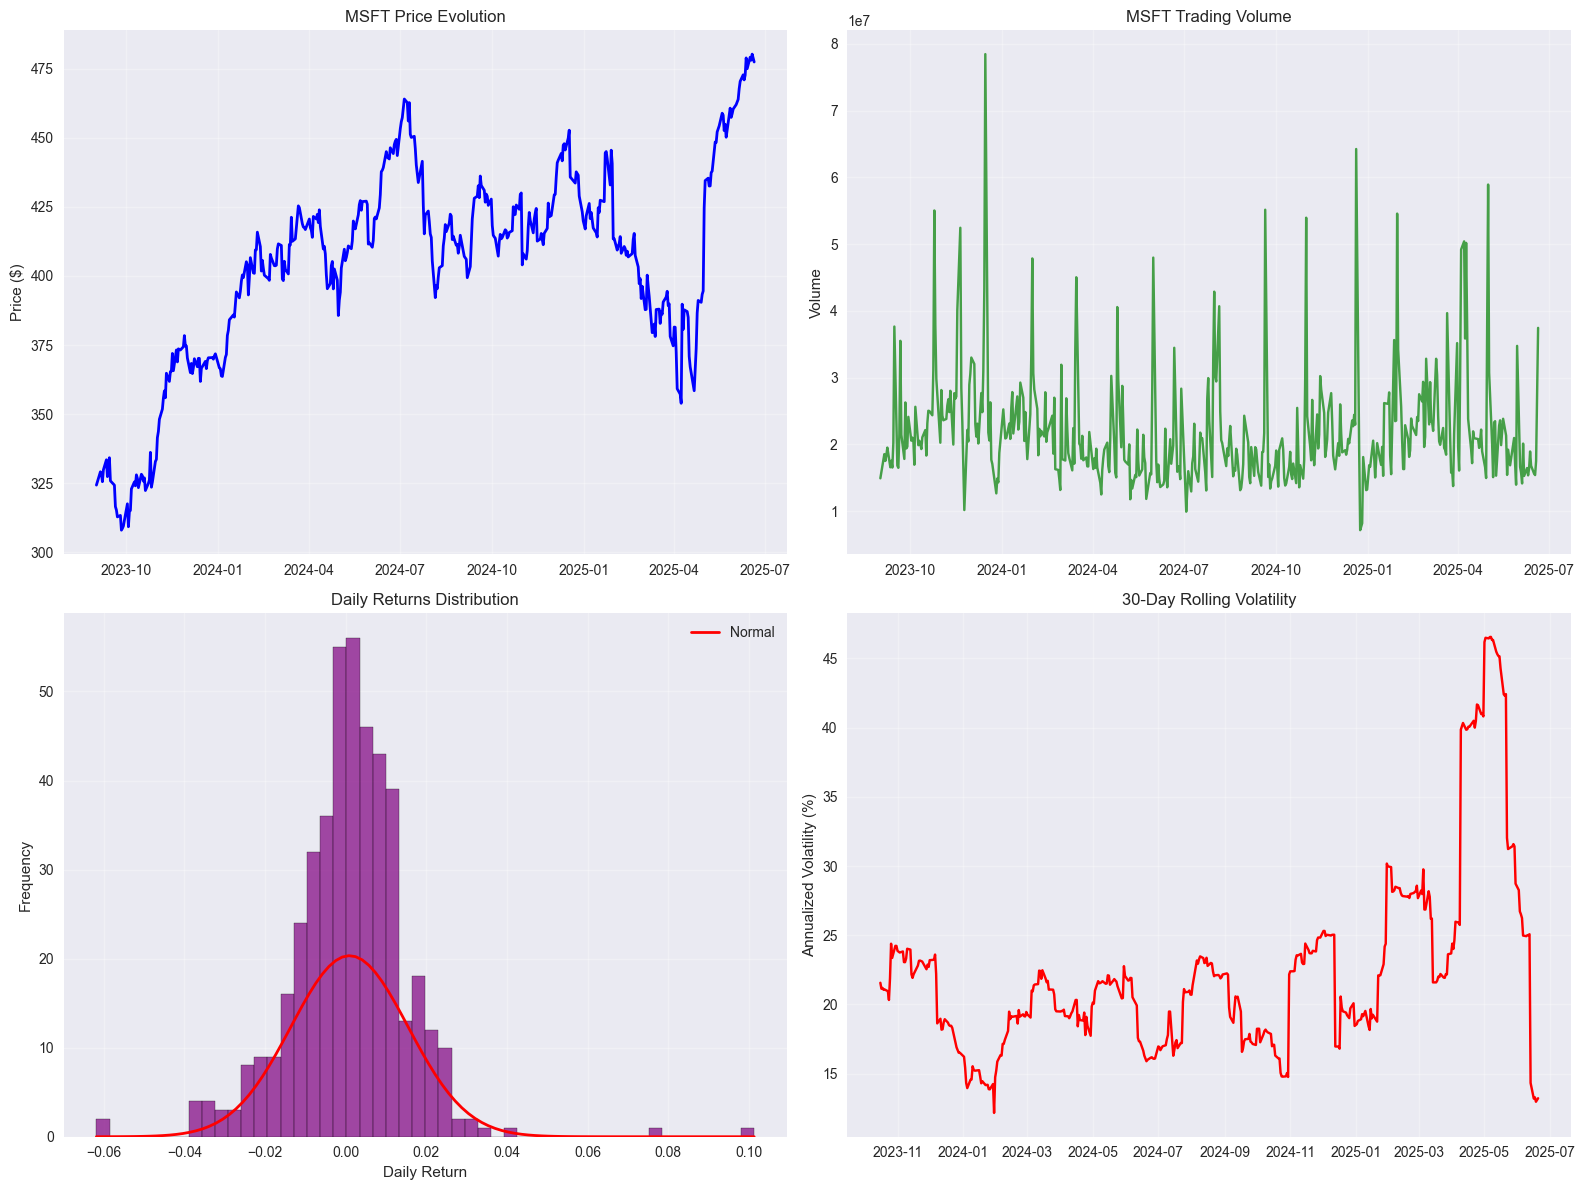


=== RETURNS ANALYSIS ===
Mean daily return: 0.0965%
Daily volatility: 1.46%
Annualized volatility: 23.10%
Skewness: 0.459
Kurtosis: 7.302
Sharpe ratio (assuming 0% risk-free rate): 1.052

Jarque-Bera normality test:
Statistic: 989.888, p-value: 0.000000
Returns are not normally distributed (α=0.05)


In [16]:
# Comprehensive price and volume analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Price evolution analysis
axes[0,0].plot(df.index, df['Close'], linewidth=2, color='blue')
axes[0,0].set_title(f'{ticker} Price Evolution')
axes[0,0].set_ylabel('Price ($)')
axes[0,0].grid(True, alpha=0.3)

# Price statistics
price_stats = {
    'Current Price': df['Close'].iloc[-1],
    'Min Price': df['Close'].min(),
    'Max Price': df['Close'].max(),
    'Price Range': df['Close'].max() - df['Close'].min(),
    'Total Return': ((df['Close'].iloc[-1] / df['Close'].iloc[0]) - 1) * 100,
    'Volatility (Annualized)': df['Close'].pct_change().std() * np.sqrt(252) * 100
}

print("=== PRICE ANALYSIS ===")
for key, value in price_stats.items():
    if 'Price' in key or 'Range' in key:
        print(f"{key}: ${value:.2f}")
    else:
        print(f"{key}: {value:.2f}%")

# Volume analysis
axes[0,1].plot(df.index, df['Volume'], color='green', alpha=0.7)
axes[0,1].set_title(f'{ticker} Trading Volume')
axes[0,1].set_ylabel('Volume')
axes[0,1].grid(True, alpha=0.3)

# Price returns distribution
returns = df['Close'].pct_change().dropna()
axes[1,0].hist(returns, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].set_title('Daily Returns Distribution')
axes[1,0].set_xlabel('Daily Return')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(True, alpha=0.3)

# Add normal distribution overlay
mu, sigma = returns.mean(), returns.std()
x = np.linspace(returns.min(), returns.max(), 100)
axes[1,0].plot(x, len(returns) * (x[1] - x[0]) * stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
axes[1,0].legend()

# Price volatility over time (rolling 30-day)
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252) * 100
axes[1,1].plot(rolling_vol.index, rolling_vol, color='red')
axes[1,1].set_title('30-Day Rolling Volatility')
axes[1,1].set_ylabel('Annualized Volatility (%)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Returns statistics
print(f"\n=== RETURNS ANALYSIS ===")
print(f"Mean daily return: {returns.mean()*100:.4f}%")
print(f"Daily volatility: {returns.std()*100:.2f}%")
print(f"Annualized volatility: {returns.std()*np.sqrt(252)*100:.2f}%")
print(f"Skewness: {returns.skew():.3f}")
print(f"Kurtosis: {returns.kurtosis():.3f}")
print(f"Sharpe ratio (assuming 0% risk-free rate): {(returns.mean()/returns.std())*np.sqrt(252):.3f}")

# Normality tests
jb_stat, jb_pvalue = jarque_bera(returns)
print(f"\nJarque-Bera normality test:")
print(f"Statistic: {jb_stat:.3f}, p-value: {jb_pvalue:.6f}")
print(f"Returns are {'normally' if jb_pvalue > 0.05 else 'not normally'} distributed (α=0.05)")

## Market Context and Relative Performance Analysis

This section analyzes the target security's performance relative to broader market indices and sector benchmarks to understand systematic versus idiosyncratic risk factors.


=== RELATIVE PERFORMANCE ANALYSIS ===
Current relative performance vs S&P 500: 8.91 percentage points
Best relative performance: 12.41 pp
Worst relative performance: -13.15 pp

VIX correlation with MSFT returns: 0.000


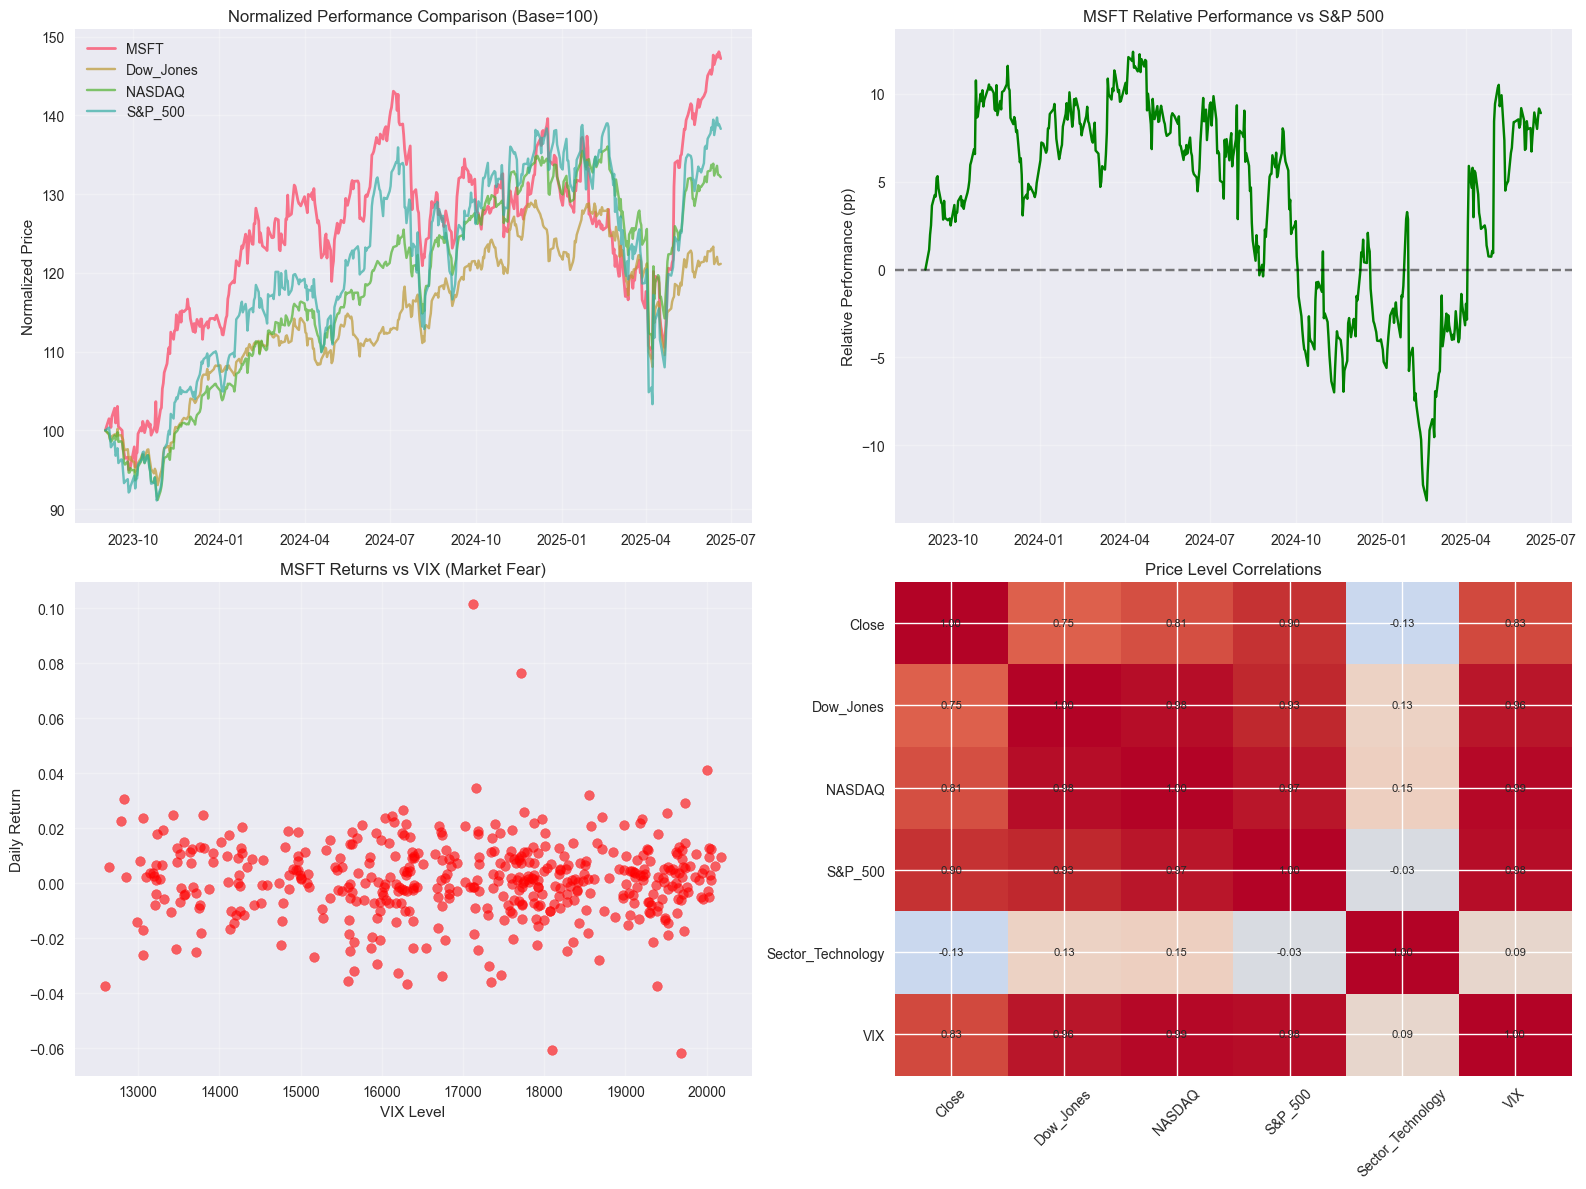


=== MARKET CORRELATION ANALYSIS ===
Return correlations with market indices:
VIX: 0.776
S&P_500: 0.771
NASDAQ: 0.729
Dow_Jones: 0.594
Sector_Technology: -0.564


In [17]:
# Market context and relative performance analysis
available_market_features = [col for col in market_cols if col in df.columns]
if available_market_features:
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Normalize prices to base 100 for comparison
    normalized_data = df[['Close'] + available_market_features].copy()
    for col in normalized_data.columns:
        normalized_data[col] = (normalized_data[col] / normalized_data[col].iloc[0]) * 100
    
    # Plot normalized performance comparison
    axes[0,0].plot(normalized_data.index, normalized_data['Close'], label=ticker, linewidth=2)
    for col in available_market_features[:3]:  # Limit to top 3 for readability
        axes[0,0].plot(normalized_data.index, normalized_data[col], label=col, alpha=0.7)
    axes[0,0].set_title('Normalized Performance Comparison (Base=100)')
    axes[0,0].set_ylabel('Normalized Price')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Calculate and plot relative performance vs S&P 500 (if available)
    sp500_col = next((col for col in available_market_features if 'S&P' in col), None)
    if sp500_col:
        relative_perf = (normalized_data['Close'] - normalized_data[sp500_col])
        axes[0,1].plot(relative_perf.index, relative_perf, color='green')
        axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0,1].set_title(f'{ticker} Relative Performance vs S&P 500')
        axes[0,1].set_ylabel('Relative Performance (pp)')
        axes[0,1].grid(True, alpha=0.3)
        
        print(f"=== RELATIVE PERFORMANCE ANALYSIS ===")
        print(f"Current relative performance vs S&P 500: {relative_perf.iloc[-1]:.2f} percentage points")
        print(f"Best relative performance: {relative_perf.max():.2f} pp")
        print(f"Worst relative performance: {relative_perf.min():.2f} pp")
    
    # VIX analysis (if available)
    vix_col = next((col for col in available_market_features if 'VIX' in col), None)
    if vix_col:
        # Plot VIX vs price returns
        price_returns = df['Close'].pct_change()
        axes[1,0].scatter(df[vix_col], price_returns, alpha=0.6, color='red')
        axes[1,0].set_xlabel('VIX Level')
        axes[1,0].set_ylabel('Daily Return')
        axes[1,0].set_title(f'{ticker} Returns vs VIX (Market Fear)')
        axes[1,0].grid(True, alpha=0.3)
        
        # Calculate correlation
        vix_corr = df[vix_col].corr(price_returns)
        print(f"\nVIX correlation with {ticker} returns: {vix_corr:.3f}")
    
    # Market correlation analysis
    market_returns = df[available_market_features].pct_change()
    stock_returns = df['Close'].pct_change()
    
    correlations = []
    for col in available_market_features:
        corr = market_returns[col].corr(stock_returns)
        correlations.append({'Market_Index': col, 'Correlation': corr})
    
    corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
    
    # Plot correlation heatmap
    if len(available_market_features) > 1:
        corr_matrix = df[['Close'] + available_market_features].corr()
        axes[1,1].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        axes[1,1].set_xticks(range(len(corr_matrix.columns)))
        axes[1,1].set_yticks(range(len(corr_matrix.columns)))
        axes[1,1].set_xticklabels(corr_matrix.columns, rotation=45)
        axes[1,1].set_yticklabels(corr_matrix.columns)
        axes[1,1].set_title('Price Level Correlations')
        
        # Add correlation values to heatmap
        for i in range(len(corr_matrix.columns)):
            for j in range(len(corr_matrix.columns)):
                axes[1,1].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                             ha='center', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== MARKET CORRELATION ANALYSIS ===")
    print("Return correlations with market indices:")
    for _, row in corr_df.iterrows():
        print(f"{row['Market_Index']}: {row['Correlation']:.3f}")

else:
    print("No market context features available for analysis")


## Technical Indicator Analysis

This section examines the behavior and effectiveness of our engineered technical indicators in capturing price momentum, trend, and volatility patterns.


=== TECHNICAL INDICATOR ANALYSIS ===
Available technical indicators: 8

RSI Analysis:
Days overbought (RSI > 70): 60 (13.3%)
Days oversold (RSI < 30): 7 (1.6%)

Bollinger Bands Analysis:
Days in squeeze (narrow bands): 90 (20.0%)
Days above upper band: 34 (7.5%)
Days below lower band: 26 (5.8%)

OBV correlation with price: 0.876

ATR Analysis:
Mean ATR: 7.76
ATR volatility: 1.67

=== TECHNICAL INDICATOR PREDICTIVE POWER ===
Correlation with next-day returns:
Bollinger_Lower: -0.0979
EMA_20: -0.0884
SMA_20: -0.0871
SMA_50: -0.0820
Bollinger_Upper: -0.0721


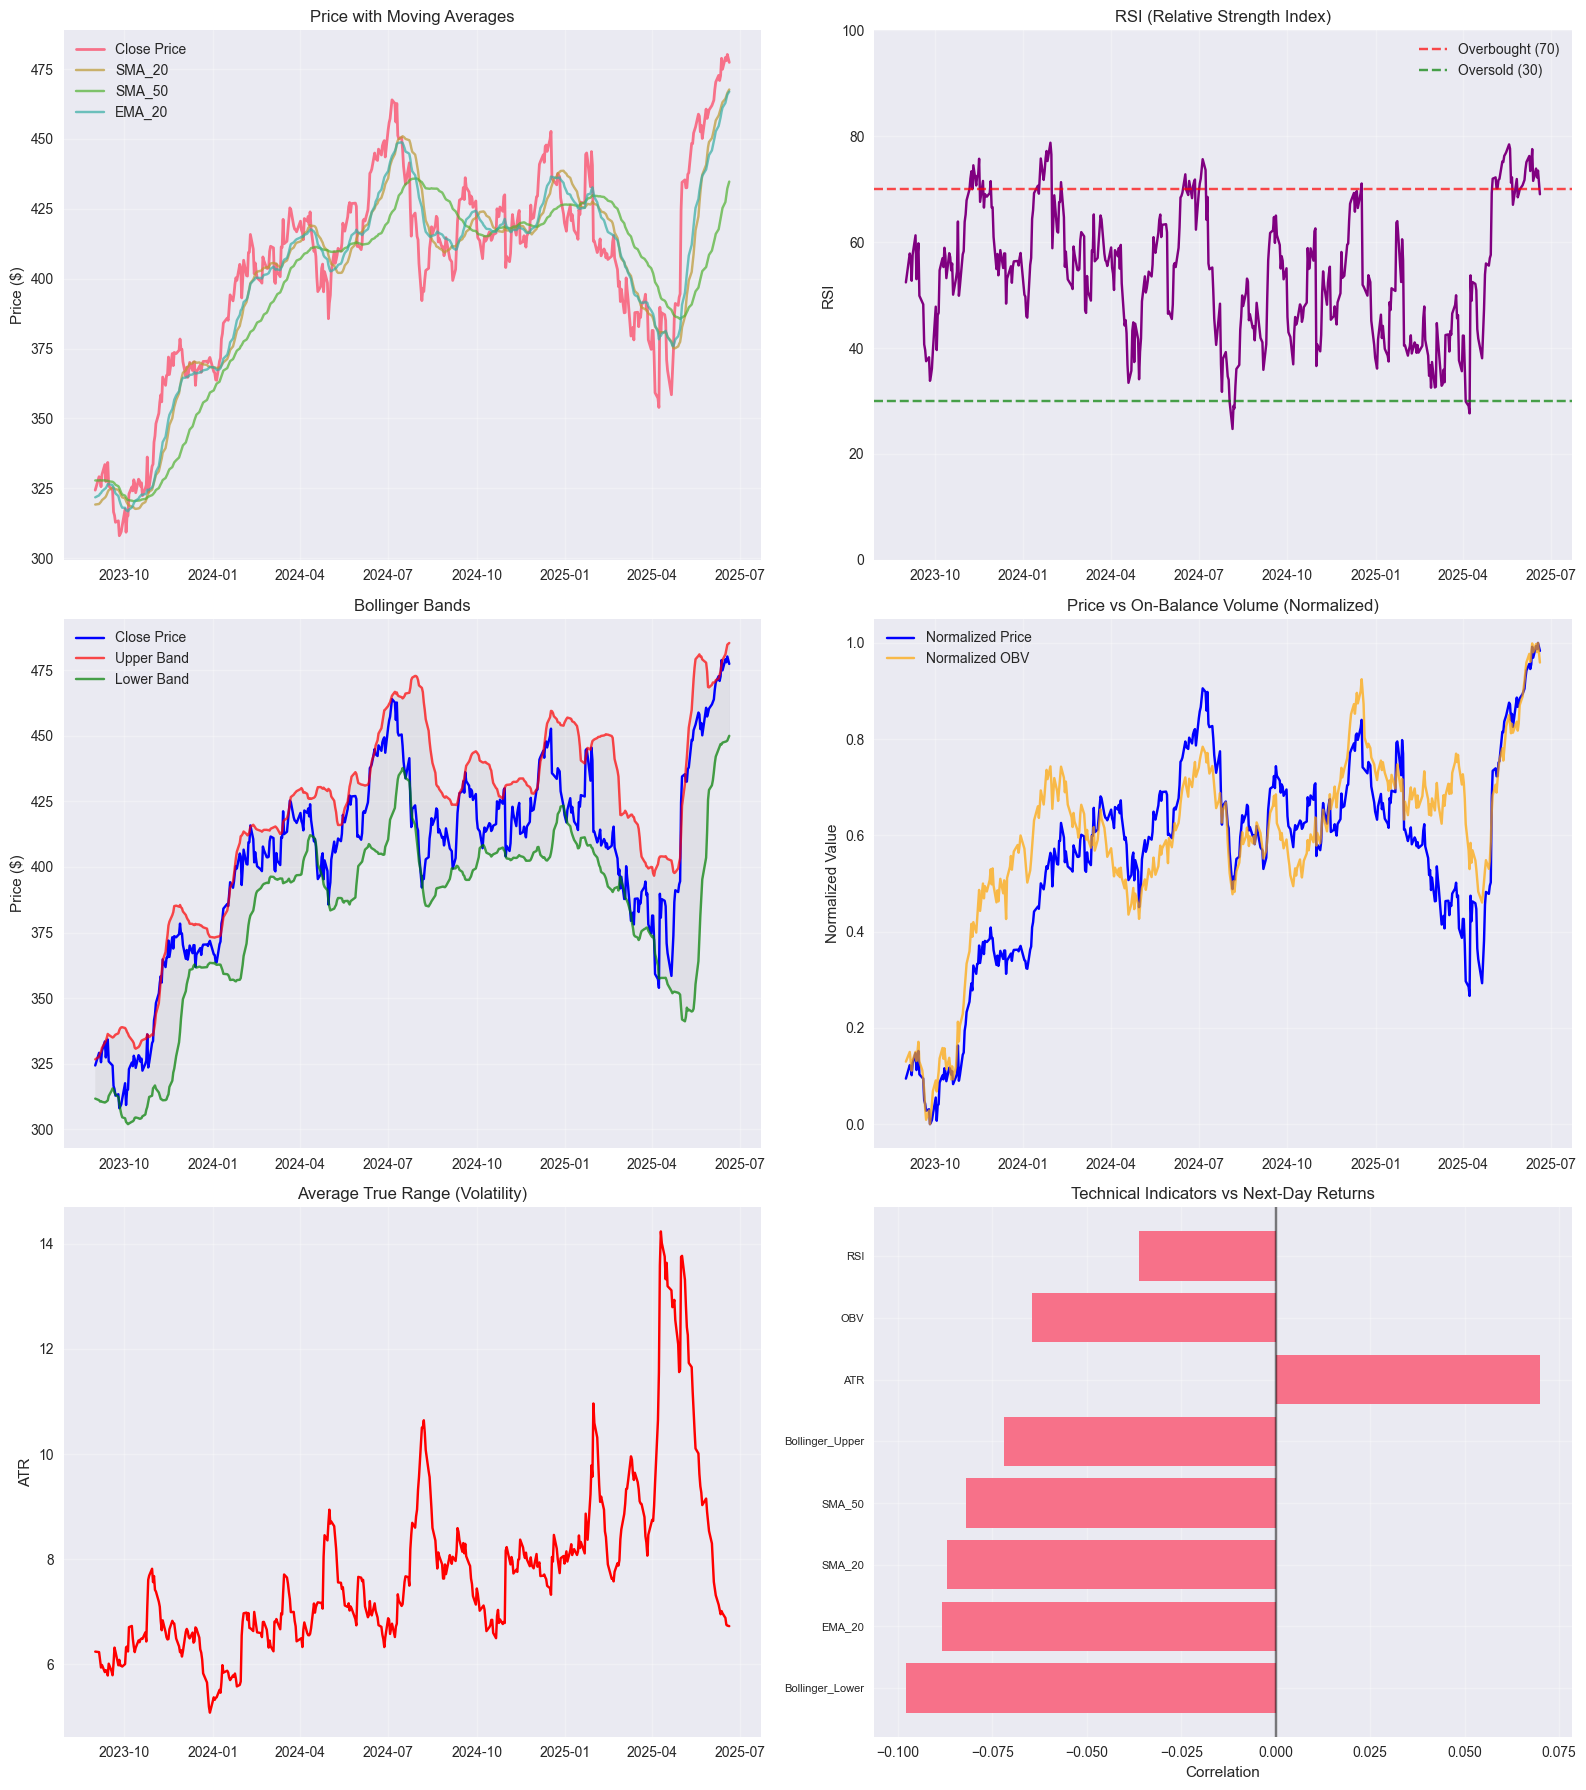

In [18]:
# Technical indicator analysis
available_tech_features = [col for col in tech_cols if col in df.columns]
if available_tech_features:
    
    print(f"=== TECHNICAL INDICATOR ANALYSIS ===")
    print(f"Available technical indicators: {len(available_tech_features)}")
    
    # Create comprehensive technical analysis plots
    n_indicators = min(len(available_tech_features), 6)  # Limit to 6 for visualization
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    axes = axes.flatten()
    
    # Plot price with moving averages
    axes[0].plot(df.index, df['Close'], label='Close Price', linewidth=2)
    sma_cols = [col for col in available_tech_features if 'SMA' in col]
    ema_cols = [col for col in available_tech_features if 'EMA' in col]
    
    for sma_col in sma_cols[:2]:  # Limit to 2 SMAs
        axes[0].plot(df.index, df[sma_col], label=sma_col, alpha=0.7)
    for ema_col in ema_cols[:2]:  # Limit to 2 EMAs
        axes[0].plot(df.index, df[ema_col], label=ema_col, alpha=0.7)
    
    axes[0].set_title('Price with Moving Averages')
    axes[0].set_ylabel('Price ($)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # RSI analysis (if available)
    rsi_col = next((col for col in available_tech_features if 'RSI' in col), None)
    if rsi_col:
        axes[1].plot(df.index, df[rsi_col], color='purple')
        axes[1].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
        axes[1].axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
        axes[1].set_title('RSI (Relative Strength Index)')
        axes[1].set_ylabel('RSI')
        axes[1].set_ylim(0, 100)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # RSI analysis
        rsi_overbought = (df[rsi_col] > 70).sum()
        rsi_oversold = (df[rsi_col] < 30).sum()
        print(f"\nRSI Analysis:")
        print(f"Days overbought (RSI > 70): {rsi_overbought} ({rsi_overbought/len(df)*100:.1f}%)")
        print(f"Days oversold (RSI < 30): {rsi_oversold} ({rsi_oversold/len(df)*100:.1f}%)")
    
    # Bollinger Bands analysis (if available)
    bb_upper = next((col for col in available_tech_features if 'Bollinger_Upper' in col), None)
    bb_lower = next((col for col in available_tech_features if 'Bollinger_Lower' in col), None)
    if bb_upper and bb_lower:
        axes[2].plot(df.index, df['Close'], label='Close Price', color='blue')
        axes[2].plot(df.index, df[bb_upper], label='Upper Band', color='red', alpha=0.7)
        axes[2].plot(df.index, df[bb_lower], label='Lower Band', color='green', alpha=0.7)
        axes[2].fill_between(df.index, df[bb_upper], df[bb_lower], alpha=0.1, color='gray')
        axes[2].set_title('Bollinger Bands')
        axes[2].set_ylabel('Price ($)')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Bollinger Band analysis
        bb_squeeze = ((df[bb_upper] - df[bb_lower]) < (df[bb_upper] - df[bb_lower]).quantile(0.2)).sum()
        price_above_upper = (df['Close'] > df[bb_upper]).sum()
        price_below_lower = (df['Close'] < df[bb_lower]).sum()
        print(f"\nBollinger Bands Analysis:")
        print(f"Days in squeeze (narrow bands): {bb_squeeze} ({bb_squeeze/len(df)*100:.1f}%)")
        print(f"Days above upper band: {price_above_upper} ({price_above_upper/len(df)*100:.1f}%)")
        print(f"Days below lower band: {price_below_lower} ({price_below_lower/len(df)*100:.1f}%)")
    
    # Volume indicators (if available)
    obv_col = next((col for col in available_tech_features if 'OBV' in col), None)
    if obv_col:
        # Normalize OBV for better visualization
        obv_normalized = (df[obv_col] - df[obv_col].min()) / (df[obv_col].max() - df[obv_col].min())
        price_normalized = (df['Close'] - df['Close'].min()) / (df['Close'].max() - df['Close'].min())
        
        axes[3].plot(df.index, price_normalized, label='Normalized Price', color='blue')
        axes[3].plot(df.index, obv_normalized, label='Normalized OBV', color='orange', alpha=0.7)
        axes[3].set_title('Price vs On-Balance Volume (Normalized)')
        axes[3].set_ylabel('Normalized Value')
        axes[3].legend()
        axes[3].grid(True, alpha=0.3)
        
        # OBV correlation with price
        obv_price_corr = df[obv_col].corr(df['Close'])
        print(f"\nOBV correlation with price: {obv_price_corr:.3f}")
    
    # ATR (Average True Range) analysis (if available)
    atr_col = next((col for col in available_tech_features if 'ATR' in col), None)
    if atr_col:
        axes[4].plot(df.index, df[atr_col], color='red')
        axes[4].set_title('Average True Range (Volatility)')
        axes[4].set_ylabel('ATR')
        axes[4].grid(True, alpha=0.3)
        
        print(f"\nATR Analysis:")
        print(f"Mean ATR: {df[atr_col].mean():.2f}")
        print(f"ATR volatility: {df[atr_col].std():.2f}")
    
    # Technical indicator correlation with returns
    if len(available_tech_features) > 0:
        returns = df['Close'].pct_change().shift(-1)  # Next day returns
        tech_correlations = []
        
        for tech_col in available_tech_features:
            corr = df[tech_col].corr(returns)
            if not np.isnan(corr):
                tech_correlations.append({'Indicator': tech_col, 'Return_Correlation': corr})
        
        if tech_correlations:
            tech_corr_df = pd.DataFrame(tech_correlations).sort_values('Return_Correlation', key=abs, ascending=False)
            
            # Plot correlation bar chart
            axes[5].barh(range(len(tech_corr_df)), tech_corr_df['Return_Correlation'])
            axes[5].set_yticks(range(len(tech_corr_df)))
            axes[5].set_yticklabels(tech_corr_df['Indicator'], fontsize=8)
            axes[5].set_title('Technical Indicators vs Next-Day Returns')
            axes[5].set_xlabel('Correlation')
            axes[5].grid(True, alpha=0.3)
            axes[5].axvline(x=0, color='black', linestyle='-', alpha=0.5)
            
            print(f"\n=== TECHNICAL INDICATOR PREDICTIVE POWER ===")
            print("Correlation with next-day returns:")
            for _, row in tech_corr_df.head(5).iterrows():
                print(f"{row['Indicator']}: {row['Return_Correlation']:.4f}")
    
    plt.tight_layout()
    plt.show()

else:
    print("No technical indicators available for analysis")


## Feature Correlation and Multicollinearity Analysis

This section examines relationships between all engineered features to identify potential multicollinearity issues and understand feature interdependencies that may impact model performance.


=== FEATURE CORRELATION ANALYSIS ===
Total numeric features: 33
High correlation pairs (|r| > 0.8): 93

Top highly correlated feature pairs:
    Feature_1 Feature_2  Correlation
7       Close       Low     0.996604
38        Low      Open     0.996601
6       Close      High     0.996556
79     SMA_20    EMA_20     0.996048
28       High      Open     0.995976
26       High       Low     0.995808
50     NASDAQ       VIX     0.992150
9       Close      Open     0.991730
63    S&P_500       VIX     0.979122
18  Dow_Jones    NASDAQ     0.978652

=== TARGET VARIABLE CORRELATION ANALYSIS ===
Features most correlated with Close:
Low: 0.9966
High: 0.9966
Open: 0.9917
EMA_20: 0.9472
Bollinger_Upper: 0.9322
SMA_20: 0.9263
S&P_500: 0.8987
OBV: 0.8758
Bollinger_Lower: 0.8606
VIX: 0.8298

=== CORRELATION DISTRIBUTION ANALYSIS ===
Mean absolute correlation: 0.402
Median absolute correlation: 0.304
Correlations > 0.5: 200 (37.9%)
Correlations > 0.8: 93 (17.6%)

=== MULTICOLLINEARITY ANALYSIS (VIF) =

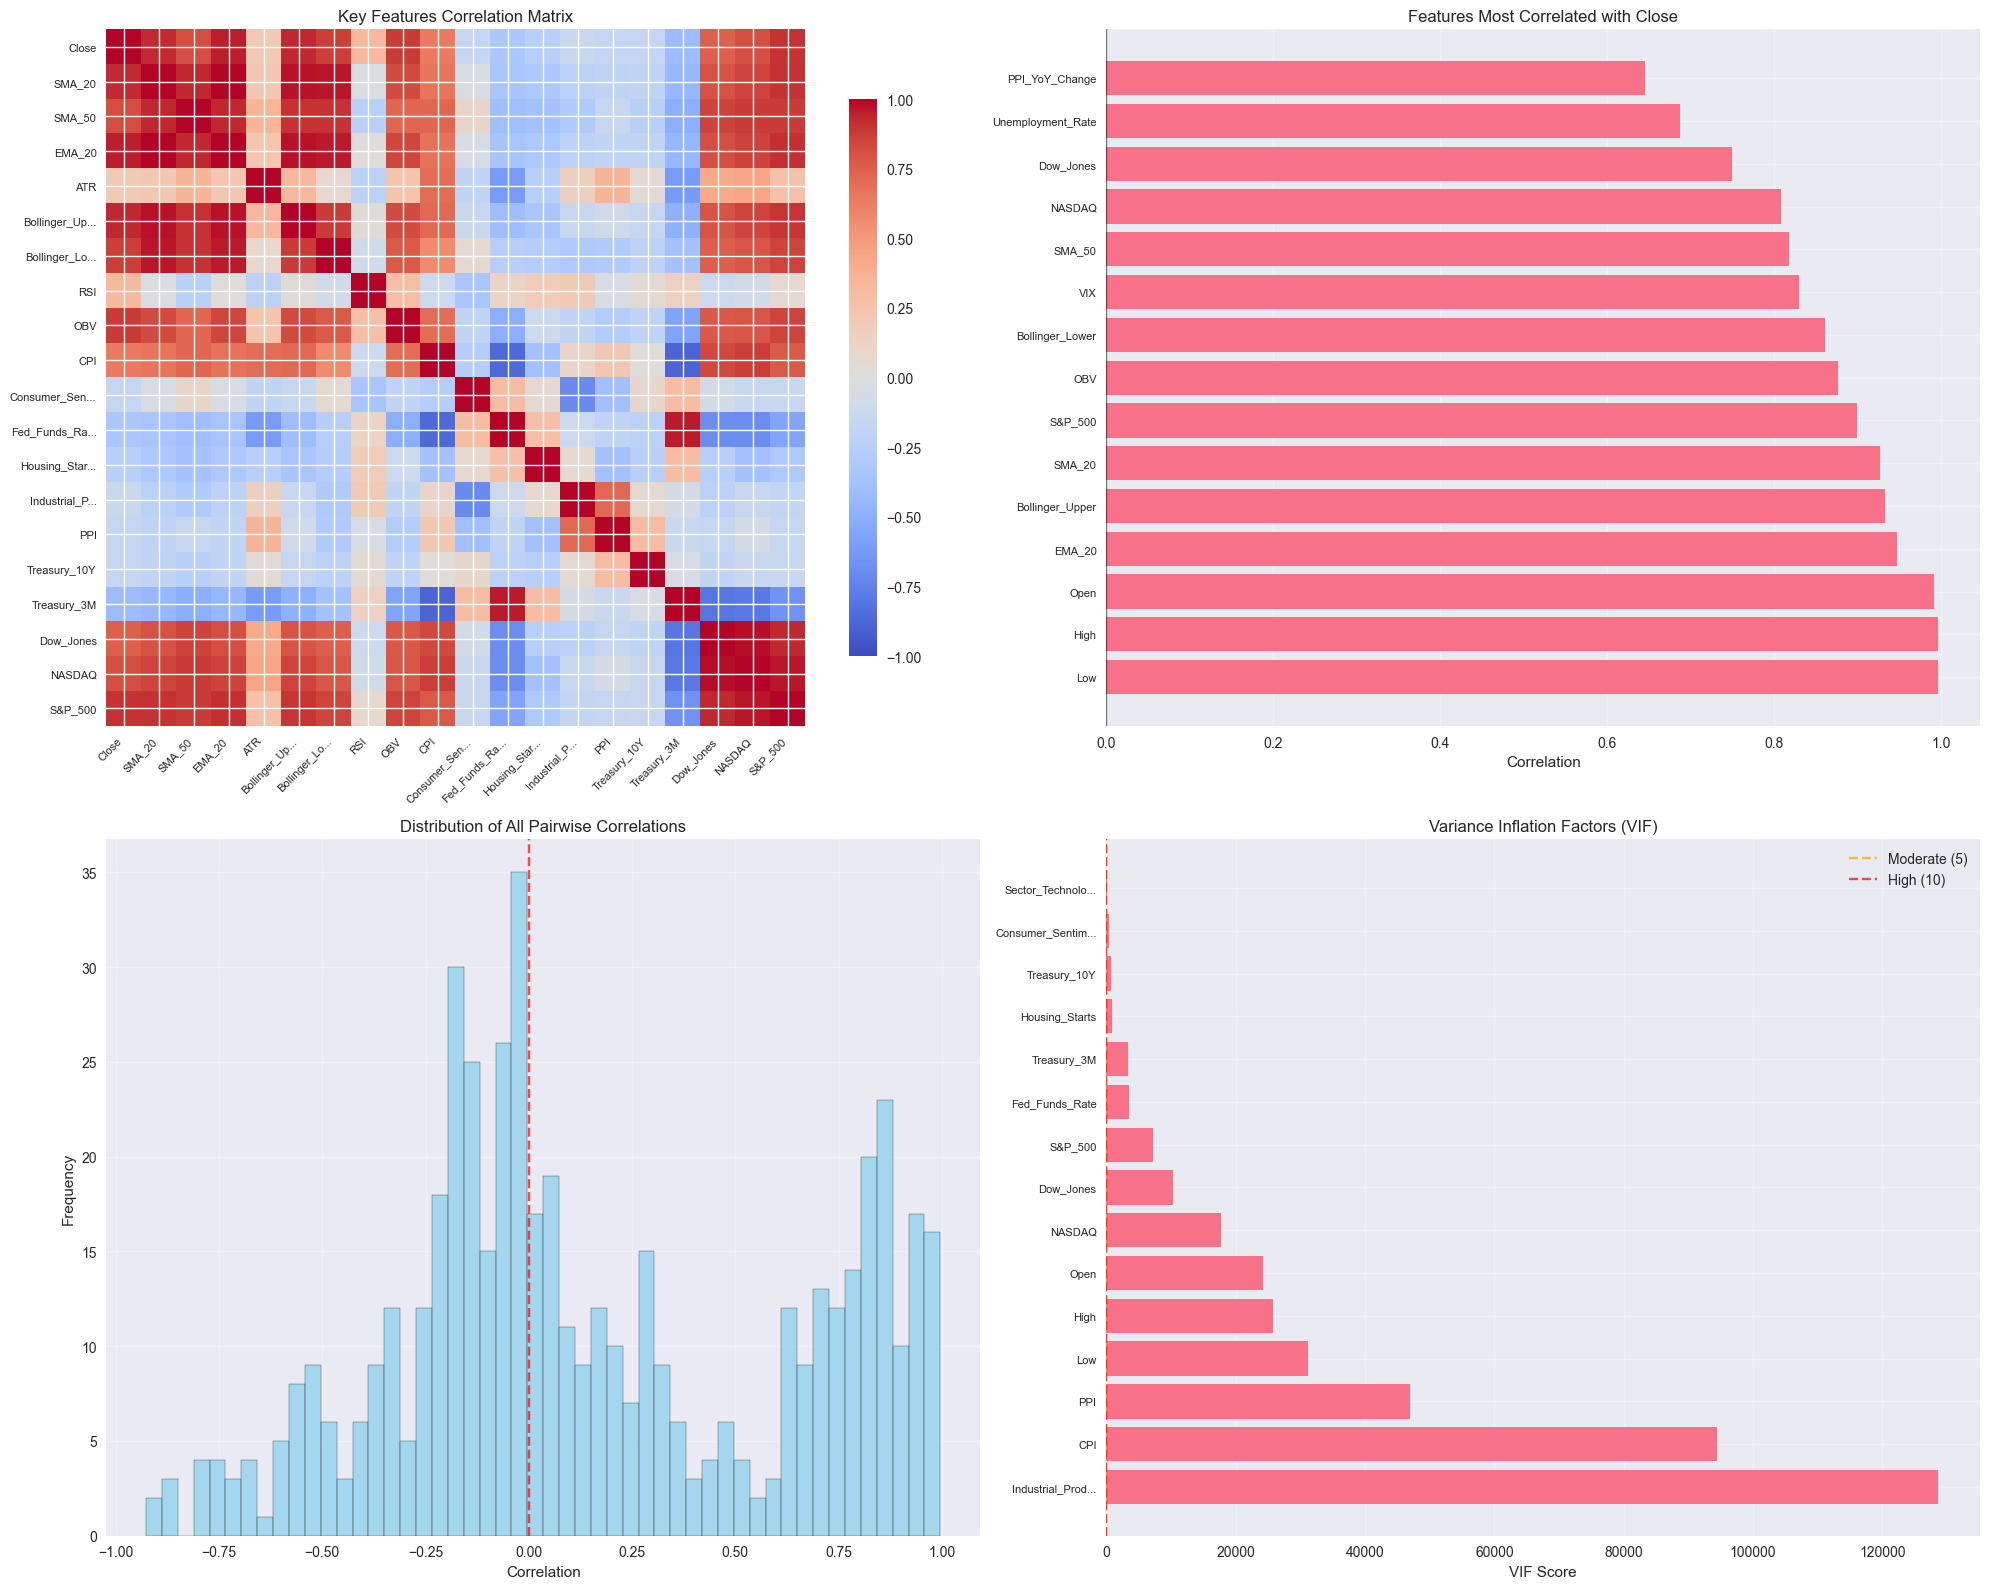


=== FEATURE IMPORTANCE RANKING (by correlation) ===
Top 10 features by absolute correlation with target:
 1. Low: +0.9966 (|0.9966|)
 2. High: +0.9966 (|0.9966|)
 3. Open: +0.9917 (|0.9917|)
 4. EMA_20: +0.9472 (|0.9472|)
 5. Bollinger_Upper: +0.9322 (|0.9322|)
 6. SMA_20: +0.9263 (|0.9263|)
 7. S&P_500: +0.8987 (|0.8987|)
 8. OBV: +0.8758 (|0.8758|)
 9. Bollinger_Lower: +0.8606 (|0.8606|)
10. VIX: +0.8298 (|0.8298|)


In [19]:
# Comprehensive correlation and multicollinearity analysis
print("=== FEATURE CORRELATION ANALYSIS ===")

# Calculate correlation matrix for all numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numeric_features].corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:  # High correlation threshold
            high_corr_pairs.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })

print(f"Total numeric features: {len(numeric_features)}")
print(f"High correlation pairs (|r| > 0.8): {len(high_corr_pairs)}")

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)
    print("\nTop highly correlated feature pairs:")
    print(high_corr_df.head(10))

# Create correlation heatmap for key features
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Full correlation matrix (subset for visibility)
key_features = [target_col] + available_tech_features[:8] + available_econ_features[:8] + available_market_features[:4]
key_features = [f for f in key_features if f in df.columns][:20]  # Limit to 20 features

if len(key_features) > 1:
    key_corr_matrix = df[key_features].corr()
    
    im1 = axes[0,0].imshow(key_corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[0,0].set_xticks(range(len(key_corr_matrix.columns)))
    axes[0,0].set_yticks(range(len(key_corr_matrix.columns)))
    axes[0,0].set_xticklabels([col[:12] + '...' if len(col) > 12 else col for col in key_corr_matrix.columns], 
                             rotation=45, ha='right', fontsize=8)
    axes[0,0].set_yticklabels([col[:12] + '...' if len(col) > 12 else col for col in key_corr_matrix.columns], 
                             fontsize=8)
    axes[0,0].set_title('Key Features Correlation Matrix')
    plt.colorbar(im1, ax=axes[0,0], shrink=0.8)

# Target variable correlation analysis
target_correlations = correlation_matrix[target_col].drop(target_col).sort_values(key=abs, ascending=False)

axes[0,1].barh(range(min(15, len(target_correlations))), target_correlations.head(15).values)
axes[0,1].set_yticks(range(min(15, len(target_correlations))))
axes[0,1].set_yticklabels([col[:20] + '...' if len(col) > 20 else col for col in target_correlations.head(15).index], 
                         fontsize=8)
axes[0,1].set_title(f'Features Most Correlated with {target_col}')
axes[0,1].set_xlabel('Correlation')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axvline(x=0, color='black', linestyle='-', alpha=0.5)

print(f"\n=== TARGET VARIABLE CORRELATION ANALYSIS ===")
print(f"Features most correlated with {target_col}:")
for feature, corr in target_correlations.head(10).items():
    print(f"{feature}: {corr:.4f}")

# Distribution of correlations
all_correlations = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
axes[1,0].hist(all_correlations, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,0].set_title('Distribution of All Pairwise Correlations')
axes[1,0].set_xlabel('Correlation')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

print(f"\n=== CORRELATION DISTRIBUTION ANALYSIS ===")
print(f"Mean absolute correlation: {np.mean(np.abs(all_correlations)):.3f}")
print(f"Median absolute correlation: {np.median(np.abs(all_correlations)):.3f}")
print(f"Correlations > 0.5: {(np.abs(all_correlations) > 0.5).sum()} ({(np.abs(all_correlations) > 0.5).mean()*100:.1f}%)")
print(f"Correlations > 0.8: {(np.abs(all_correlations) > 0.8).sum()} ({(np.abs(all_correlations) > 0.8).mean()*100:.1f}%)")

# Variance Inflation Factor (VIF) analysis for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select features for VIF analysis (limit to avoid computational issues)
vif_features = [f for f in numeric_features if f != target_col][:15]  # Limit to 15 features

if len(vif_features) > 1:
    try:
        vif_data = df[vif_features].dropna()
        
        if len(vif_data) > 0 and vif_data.shape[1] > 1:
            vif_scores = []
            for i, feature in enumerate(vif_features):
                if vif_data[feature].var() > 0:  # Check for non-zero variance
                    vif = variance_inflation_factor(vif_data.values, i)
                    vif_scores.append({'Feature': feature, 'VIF': vif})
            
            if vif_scores:
                vif_df = pd.DataFrame(vif_scores).sort_values('VIF', ascending=False)
                
                # Plot VIF scores
                axes[1,1].barh(range(len(vif_df)), vif_df['VIF'])
                axes[1,1].set_yticks(range(len(vif_df)))
                axes[1,1].set_yticklabels([col[:15] + '...' if len(col) > 15 else col for col in vif_df['Feature']], fontsize=8)
                axes[1,1].set_title('Variance Inflation Factors (VIF)')
                axes[1,1].set_xlabel('VIF Score')
                axes[1,1].axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='Moderate (5)')
                axes[1,1].axvline(x=10, color='red', linestyle='--', alpha=0.7, label='High (10)')
                axes[1,1].legend()
                axes[1,1].grid(True, alpha=0.3)
                
                print(f"\n=== MULTICOLLINEARITY ANALYSIS (VIF) ===")
                print("Features with potential multicollinearity issues:")
                high_vif = vif_df[vif_df['VIF'] > 5]
                if len(high_vif) > 0:
                    for _, row in high_vif.iterrows():
                        severity = "High" if row['VIF'] > 10 else "Moderate"
                        print(f"{row['Feature']}: {row['VIF']:.2f} ({severity})")
                else:
                    print("No significant multicollinearity detected (all VIF < 5)")
    
    except Exception as e:
        print(f"VIF calculation failed: {e}")
        axes[1,1].text(0.5, 0.5, 'VIF calculation\nnot available', 
                      transform=axes[1,1].transAxes, ha='center', va='center')

plt.tight_layout()
plt.show()

# Feature importance based on correlation with target
feature_importance_corr = pd.DataFrame({
    'Feature': target_correlations.index,
    'Abs_Correlation': np.abs(target_correlations.values),
    'Correlation': target_correlations.values
}).sort_values('Abs_Correlation', ascending=False)

print(f"\n=== FEATURE IMPORTANCE RANKING (by correlation) ===")
print("Top 10 features by absolute correlation with target:")
for i, (_, row) in enumerate(feature_importance_corr.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']}: {row['Correlation']:+.4f} (|{row['Abs_Correlation']:.4f}|)")


## Modeling Approach Rationale

Our analysis reveals that the price series is non-stationary and features exhibit high multicollinearity (VIF scores exceeding 100,000). Despite these traditional statistical concerns, we will proceed with all engineered features for the following reasons:

**Primary Models - Tree-Based Methods:** Random Forest, XGBoost, CatBoost, and LightGBM are inherently robust to multicollinearity and non-stationary data. These algorithms handle feature redundancy through their splitting mechanisms and can capture complex temporal patterns without requiring stationarity assumptions.

**Secondary Models - Linear Methods:** Ridge, Lasso, and Huber regression will be included for comparison purposes. While these models may struggle with the data characteristics, they serve as benchmarks to validate the superiority of tree-based approaches for this dataset.

**Feature Strategy:** We retain all engineered features as tree-based models can effectively utilize redundant information by selecting the most informative variables at each decision point. This approach prioritizes predictive performance over traditional statistical preprocessing requirements.